Zach's EDA Jupyter Notebook
TODO:
-Add GEOID to all tables

Access database, find all tables

In [38]:
import pandas as pd
import numpy as np
import oracledb
import logging
from geopy.geocoders import Nominatim
from pathlib import Path
from numba import njit
from pathlib import Path
from IPython import get_ipython
current_file = Path(get_ipython().run_line_magic('pwd', '')).resolve()


#Connect to database
password = 'aybM6CFL9gykHEKn'
wallet_password = 'phbUHx6CMjxQj75A'

connect:str = input("Connect to the database y/n: \n")
if connect.lower() == 'y':
    connection = oracledb.connect(
        user="admin",
        password=password,
        dsn = "ltl3y0m4d7of29l1_high",
        config_dir=(str(current_file.parent / 'config')),
        wallet_location=(str(current_file.parent / 'config')),
        wallet_password=wallet_password)

    logging.info("Successfully connected to Oracle Database")
    cursor = connection.cursor()
else:
    print("Didn't connect to the database")

In [39]:
cursor.execute("SELECT table_name FROM user_tables")
table_names = [row[0] for row in cursor.fetchall()]
print(f"Tables in the database: {table_names}")

Tables in the database: ['CENSUS', 'HISTORIC_REAL_ESTATE', 'CALLS', 'TEST_TABLE', 'HISTORIC_CRIME', 'CALLS_DUP', 'CRIME', 'SDW$ERR$_CRIME']


Calls section

In [40]:
import pandas as pd
calls = pd.read_sql("Select * from Calls", connection)
#calls.fillna(0,inplace = True)
calls.head()

/var/folders/fy/6nhb1jds74vcbb55n83td9ph0000gn/T/ipykernel_75061/480166161.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  calls = pd.read_sql("Select * from Calls", connection)


,CALL_NUMBER,DATE_TIME,LOCATION,POLICE_DISTRICT,NATURE_OF_CALL,STATUS,LATITUDE,LONGITUDE,GEOID
0,230440688,02/13/2023 01:57:37 PM,"2715 S 28TH ST,MKE",2,ENTRY,Service in Progress,42.995394,-87.949719,55079018900
1,230440614,02/13/2023 01:51:36 PM,5909 N MILWAUKEE RIVER PARKWAY,1,PRISONER TRANS,Service in Progress,43.125401,-87.929881,55079060200
2,230440672,02/13/2023 01:43:47 PM,"4224 W JUNEAU AV,MKE",3,CALL FOR POLICE,Advised,43.046080,-87.967901,55079012400
3,230440674,02/13/2023 01:42:36 PM,"245 W LINCOLN AV,MKE",2,RETURN STATION,Assignment Completed,43.002518,-87.913685,55079186600
4,230440657,02/13/2023 01:41:19 PM,"2460 N 9TH ST,MKE",3,THEFT VEHICLE,Unable to Locate Complainant,43.063239,-87.922582,55079185500


In [41]:
calls.NATURE_OF_CALL.value_counts()[:10]

NATURE_OF_CALL
RETURN STATION     2830
TRAFFIC STOP       2673
TRBL W/SUBJ        2554
BUSINESS CHECK     2084
WELFARE CITIZEN    2029
PATROL             1761
SPECIAL ASSIGN     1698
FOLLOW UP          1670
SHOTSPOTTER        1385
ACC PDO            1329
Name: count, dtype: int64

In [42]:
from datetime import datetime
datetime.strptime(calls.DATE_TIME[0], '%m/%d/%Y %I:%M:%S %p')
calls['datetime_column'] = calls.DATE_TIME.apply(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'))
calls['Hour'] = calls.datetime_column.apply(lambda x: x.hour)
calls['DayOfWeek'] = calls.datetime_column.apply(lambda x: x.weekday())

<Axes: xlabel='datetime_column', ylabel='Count'>

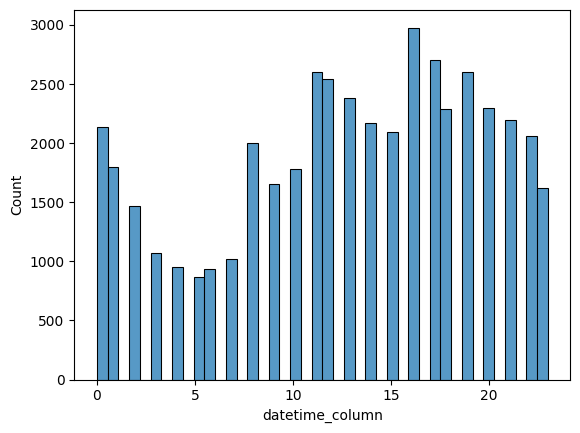

In [43]:
import seaborn as sns 
sns.histplot(calls.datetime_column.apply(lambda x: x.hour))

In [44]:
import matplotlib.pyplot as plt
top_10_natures = calls.NATURE_OF_CALL.value_counts()[0:10].index
#t10_natures_df = calls.NATURE_OF_CALL[calls.NATURE_OF_CALL.isin(top_10_natures)]
#sns.histplot(t10_natures_df)
## Disable the x-axis
#plt.setp(plt.gca().get_xticklabels(), visible=False);
print(top_10_natures)

Index(['RETURN STATION', 'TRAFFIC STOP', 'TRBL W/SUBJ', 'BUSINESS CHECK',
       'WELFARE CITIZEN', 'PATROL', 'SPECIAL ASSIGN', 'FOLLOW UP',
       'SHOTSPOTTER', 'ACC PDO'],
      dtype='object', name='NATURE_OF_CALL')


Geospacial data processing section

In [45]:
#Must use GEOID's as keys
unique_natures = list(calls.NATURE_OF_CALL.unique())
cols_natures = ['NUM-' + nature.replace(' ','_') +'_CALLS' for nature in unique_natures]

In [46]:
census = pd.read_sql("Select * from census", connection)
census.drop(['GEOMETRY','TRACT'], inplace = True, axis=1)

/var/folders/fy/6nhb1jds74vcbb55n83td9ph0000gn/T/ipykernel_75061/804108482.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  census = pd.read_sql("Select * from census", connection)


In [47]:
%%capture
for col in cols_natures:
    census[col] = np.zeros(len(census.GEOID))

In [48]:
calls.head(2)

,CALL_NUMBER,DATE_TIME,LOCATION,POLICE_DISTRICT,NATURE_OF_CALL,STATUS,LATITUDE,LONGITUDE,GEOID,datetime_column,Hour,DayOfWeek
0,230440688,02/13/2023 01:57:37 PM,"2715 S 28TH ST,MKE",2,ENTRY,Service in Progress,42.995394,-87.949719,55079018900,2023-02-13 13:57:37,13,0
1,230440614,02/13/2023 01:51:36 PM,5909 N MILWAUKEE RIVER PARKWAY,1,PRISONER TRANS,Service in Progress,43.125401,-87.929881,55079060200,2023-02-13 13:51:36,13,0


In [49]:
census.head(3)

,GEOID,ESTIMATED_POP,MALE_POP,FEMALE_POP,MEDIAN_AGE,MEDIAN_INCOME,WHITE_POP,BLACK_POP,NATIVE_POP,HISPANIC_POP,...,NUM-TAVERN_VIOLATION_CALLS,NUM-RECOVERED_PROP_CALLS,NUM-TRAFFIC_CONTROL_CALLS,NUM-DEMONSTRATION_CALLS,NUM-WATER_MAIN_BREAK_CALLS,NUM-METH_LAB_CALLS,NUM-BOAT_STOP_CALLS,NUM-ASSIST_OFFICER_CALLS,NUM-THREAT_OFFICER_CALLS,NUM-CONT_DEL_MINOR_CALLS
0,55079008700,890.0,403.0,487.0,32.9,13782.0,0.0,890.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55079008800,1620.0,795.0,825.0,32.5,16713.0,90.0,1498.0,4.0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,55079008500,1540.0,756.0,784.0,29.5,19546.0,6.0,1517.0,17.0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
def add_calls_to_census(row):
    geoid = row['GEOID']
    census.loc[census['GEOID'] == geoid,'NUM-'+row['NATURE_OF_CALL'].replace(' ','_')+'_CALLS'] += 1

calls.apply(lambda row: add_calls_to_census(row),axis = 1);

In [51]:
#Fix the HISPANIC_POP
def recalculate_hisp_pop(row):
    row['HISPANIC_POP'] = str(float(row['ESTIMATED_POP']) - float(row['WHITE_POP']) - float(row['BLACK_POP']) - float(row['NATIVE_POP']))
    return row

census = census.apply(lambda row: recalculate_hisp_pop(row), axis=1)

In [52]:
census['ESTIMATED_POP'] = census['ESTIMATED_POP'].astype(float).astype(int)
census = census[census['ESTIMATED_POP'] != 0]

In [53]:
def make_majority(row):
    row['MAJORITY_RACE'] = np.argmax([row.WHITE_POP,row.BLACK_POP,row.NATIVE_POP,row.HISPANIC_POP])
    return row

majority_dict = {
    0:'White',
    1:'Black',
    2:'Native',
    3:'Hispanic'
}
census = census.apply(lambda row: make_majority(row),axis = 1)

In [54]:
%%capture
#Create new columns in the census df which contain the name of all of the "NATURE_OF_CALLS" per population
#census['PATROLS_PER_POP'] = census['NUM-PATROL_CALLS'].astype(float)/census['ESTIMATED_POP'].astype(float)
columns = [c for c in census.columns if "CALLS" in c]
for col in columns:
    census[col+"_PER_POP"] = census[col].astype(float)/census['ESTIMATED_POP'].astype(float)

In [57]:
columns = [c for c in census.columns if "PATROL" in c]
columns

['NUM-PATROL_CALLS', 'NUM-PATROL_CALLS_PER_POP']

In [60]:
import itertools
combinations = itertools.combinations(list(range(4)),2)
import scipy.stats as stats

def compute_mannwhitney(idx_pop_1,idx_pop_2,comparison_column):
    pop_1 = list(census[comparison_column][census['MAJORITY_RACE'] == idx_pop_1])
    pop_2 = list(census[comparison_column][census['MAJORITY_RACE'] == idx_pop_2])
    test = stats.mannwhitneyu(pop_1,pop_2,alternative='two-sided')
    x = ""
    if test.pvalue <.05:
        x = "!"
    if test.pvalue <.01:
        x = "!!"
    if test.pvalue <.001:
        x = "!!!"
    if test.pvalue <.0001:
        x = "!!!!"
    if test.pvalue <.00001:
        x = "!!!!!"
    print(f"{majority_dict[idx_pop_1]}: {np.round(np.mean(pop_1),5)} and {majority_dict[idx_pop_2]}: {np.round(np.mean(pop_2),5)} comparing {comparison_column} yields p-val of {test.pvalue} {x}")
    return test.pvalue
    
print("MannWhitney tests for testing difference of means between two populations")
for combination in combinations:
    x,y = combination
    compute_mannwhitney(x,y,'NUM-PATROL_CALLS_PER_POP')

MannWhitney tests for testing difference of means between two populations
White: 0.00282 and Black: 0.00251 comparing NUM-PATROL_CALLS_PER_POP yields p-val of 0.025077871523739158 !
White: 0.00282 and Native: 0.00204 comparing NUM-PATROL_CALLS_PER_POP yields p-val of 0.06732519883806944 
White: 0.00282 and Hispanic: 0.00202 comparing NUM-PATROL_CALLS_PER_POP yields p-val of 0.030367418306414866 !
Black: 0.00251 and Native: 0.00204 comparing NUM-PATROL_CALLS_PER_POP yields p-val of 0.9217149965915865 
Black: 0.00251 and Hispanic: 0.00202 comparing NUM-PATROL_CALLS_PER_POP yields p-val of 0.8758977197676252 
Native: 0.00204 and Hispanic: 0.00202 comparing NUM-PATROL_CALLS_PER_POP yields p-val of 0.9126734710473161 


INDS FINAL DOCUMENT

SHOT ANALYSIS

In [62]:
colum = list(census.columns)
shooting_columns = [s for s in colum if ("SHOT" in s or "SHOOT" in s) and ("PER_POP" in s)]
shooting_columns

['NUM-SHOTS_FIRED_CALLS_PER_POP',
 'NUM-SHOTSPOTTER_CALLS_PER_POP',
 'NUM-SHOOTING_CALLS_PER_POP']

In [63]:
import itertools

print("MannWhitney tests for testing difference of means between two populations")
for col in shooting_columns:
    combinations = itertools.combinations(list(range(4)),2)
    for combination in combinations:
        x,y = combination
        compute_mannwhitney(x,y,col)

MannWhitney tests for testing difference of means between two populations
White: 0.00138 and Black: 0.00065 comparing NUM-SHOTS_FIRED_CALLS_PER_POP yields p-val of 0.0007869131495021943 !!!
White: 0.00138 and Native: 0.00054 comparing NUM-SHOTS_FIRED_CALLS_PER_POP yields p-val of 0.00018915063445743428 !!!
White: 0.00138 and Hispanic: 0.00085 comparing NUM-SHOTS_FIRED_CALLS_PER_POP yields p-val of 0.003858946379117825 !!
Black: 0.00065 and Native: 0.00054 comparing NUM-SHOTS_FIRED_CALLS_PER_POP yields p-val of 0.5644543159900753 
Black: 0.00065 and Hispanic: 0.00085 comparing NUM-SHOTS_FIRED_CALLS_PER_POP yields p-val of 0.4144687630183367 
Native: 0.00054 and Hispanic: 0.00085 comparing NUM-SHOTS_FIRED_CALLS_PER_POP yields p-val of 0.16024457385389668 
White: 0.0045 and Black: 0.00148 comparing NUM-SHOTSPOTTER_CALLS_PER_POP yields p-val of 0.012522375649959784 !
White: 0.0045 and Native: 0.00147 comparing NUM-SHOTSPOTTER_CALLS_PER_POP yields p-val of 0.1113199640811407 
White: 0.0045 

Census section

In [ ]:
#census = pd.read_sql("Select * from census", connection)
#census.drop(['GEOMETRY','TRACT'], inplace = True, axis=1)
#census.head()

Real estate section

In [ ]:
real_estate = pd.read_sql("Select * from historic_real_estate", connection)
real_estate.head()

/var/folders/fy/6nhb1jds74vcbb55n83td9ph0000gn/T/ipykernel_69707/4161431809.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  real_estate = pd.read_sql("Select * from historic_real_estate", connection)


,PROPTYPE,ADDRESS,SALE_DATE,SALE_PRICE,LATITUDE,LONGITUDE
0,Residential,6261 N JOYCE AV,2012-05,80000,43.131774,-88.017959
1,Residential,5227 N 60TH ST,2012-05,104000,43.112705,-87.986525
2,Residential,1725 N MARSHALL ST,2012-05,87000,43.053582,-87.901090
3,Residential,2940 N CAMBRIDGE AV,2012-05,229500,43.072010,-87.891307
4,Residential,2228 E NEWBERRY BL,2012-05,640000,43.069707,-87.882044


In [ ]:
import random

def assign_rand_id(row):
    row['id'] = random.choice(['123','456','789'])
    return row

real_estate = real_estate.apply(lambda row: assign_rand_id(row),axis = 1)
real_estate

,PROPTYPE,ADDRESS,SALE_DATE,SALE_PRICE,LATITUDE,LONGITUDE,id
0,Residential,6261 N JOYCE AV,2012-05,80000,43.131774,-88.017959,789
1,Residential,5227 N 60TH ST,2012-05,104000,43.112705,-87.986525,789
2,Residential,1725 N MARSHALL ST,2012-05,87000,43.053582,-87.901090,456
3,Residential,2940 N CAMBRIDGE AV,2012-05,229500,43.072010,-87.891307,456
4,Residential,2228 E NEWBERRY BL,2012-05,640000,43.069707,-87.882044,123
...,...,...,...,...,...,...,...
58365,Residential,3666 S 91ST ST,2017-04,184000,42.977694,-88.026099,123
58366,Residential,3170 S 38TH ST,2017-04,159000,42.986809,-87.961520,123
58367,Residential,2916 S 48TH ST,2017-04,178000,42.991591,-87.973779,456
58368,Residential,2819 S 69TH ST,2017-04,149000,42.993329,-87.999207,456


In [ ]:
real_estate.groupby('id')['SALE_PRICE'].mean()

id
123    250511.193329
456    234053.689802
789    231554.280690
Name: SALE_PRICE, dtype: float64

Historic crime section

In [ ]:
hist_crime = pd.read_sql("Select * from historic_crime", connection)
hist_crime.head()

C:\Users\zfara\AppData\Local\Temp\ipykernel_11864\2741180405.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hist_crime = pd.read_sql("Select * from historic_crime", connection)


,CALL_NUMBER,DATE_TIME,REPORTED_YEAR,REPORTED_MONTH,ADDRESS,WEAPON_USED,ALD,NSP,DISTRIC,TRACT,...,ARSON,ASSAULTOFFENSE,BURGLARY,CRIMINALDAMAGE,HOMICIDE,LOCKEDVEHICLE,ROBBERY,SEXOFFENSE,THEFT,VEHICLETHEFT
0,050020025,2005-01-02 17:03:00,2005,1,2424 N FRATNEY ST,None,3.0,7.0,5.0,10700.0,...,0,0,0,1,0,0,0,0,0,0
1,050020026,2005-01-02 15:15:00,2005,1,2122 S LAYTON BL,None,8.0,17.0,2.0,17300.0,...,0,0,0,0,0,0,0,0,1,0
2,050020027,2005-01-02 18:01:00,2005,1,2640 S 30TH ST,None,8.0,NaN,2.0,18900.0,...,0,0,0,1,0,0,0,0,0,0
3,050020028,2005-01-02 17:48:00,2005,1,3163 N FRATNEY ST,None,3.0,NaN,5.0,7100.0,...,0,0,0,1,0,0,0,0,0,0
4,050020029,2005-01-02 11:30:00,2005,1,8129 W BENDER AV,None,2.0,2.0,4.0,1400.0,...,0,0,0,0,0,0,0,0,0,1


Crime section

In [ ]:
crime = pd.read_sql("Select * from crime", connection)
crime.head()

C:\Users\zfara\AppData\Local\Temp\ipykernel_11864\2187178922.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  crime = pd.read_sql("Select * from crime", connection)


,CALL_NUMBER,DATE_TIME,ADDRESS,POLICE_DISTRICT,NATURE_OF_CALL,STATUS,LATITUDE,LONGITUDE
0,230311239,01/31/2023 04:42:12 PM,"N 35TH ST / W PARK HILL AV,MKE",3,ACC PI,Service in Progress,43.085368,-87.957141
1,230311241,01/31/2023 04:42:05 PM,"2222 S 37TH ST,MKE",2,INVESTIGATION,Assignment Completed,43.004218,-87.960256
2,230311230,01/31/2023 04:39:09 PM,"212 W WISCONSIN AV,MKE",1,SUSP PERS/AUTO,Unable to Locate Complainant,43.039249,-87.913401
3,230311236,01/31/2023 04:38:12 PM,"4204 W CAPITOL DR,MKE",7,TRAFFIC STOP,Advised,43.089974,-87.965580
4,230311235,01/31/2023 04:36:54 PM,"N TEUTONIA AV / W VILLARD AV,MKE",7,INVESTIGATION,Assignment Completed,43.071124,-87.930350
